<a href="https://colab.research.google.com/github/giacomogreggio/Algoritmi_avanzati/blob/master/Alg_Av_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This is a python notebook containing the execution of the first homework of the course "Advanced Algorithms 2019/2020".
  
Inside this notebook we will analize some of the most common algorithms used to find the Minimum Spanning Tree(MST) of a graph.

In particular we will implement and analize the following algorithms:
* Prim
* Kruskal Naive
* Kruskal With Union Find


# Minimum Spanning Trees(MSTs)

A minimum spanning tree (MST) or minimum weight spanning tree is a subset of the edges of a connected, edge-weighted undirected graph that connects all the vertices together, without any cycles and with the minimum possible total edge weight. That is, it is a spanning tree whose sum of edge weights is as small as possible.
All the algorithms that we will see are based on the following generic algorithm:


```
A=empty set
while A doesn't form a spanning tree
  find an edge (u,v) that is safe for A
  A = A U {(u,v)}
return A
```
How do we find a safe edge? By exploiting the following structural properties of the MSTs. First some definitions:
* A **cut** (S,V\S) of a graph G=(V,E) is a partition of V
* An edge (u,v) **belongs** to the set E if crosses the cut (S,V\S) if u belongs to S and v belongs to V\S or viceversa.
* A cut **respects** a set A of edges if no edge of A crosses the cut
* Given a cut the edge of minimum weight that crosses it is called **light edge**
  
**Theorem**:  
Given a fully connected, non directed and weighted graph G=(V,E), if A is a subset of E included in some MST of the graph G, and if (S, S\V) is a cut that respects A, and if (u,v) is a light edge for (S, V\S) then (u,v) is a safe edge for A


# Importing the dependencies

In [0]:
import math
import time
from google.colab import drive
import random
import os
import matplotlib.pylab as plt
%matplotlib inline
from statistics import mean

# Notebook configuration


This section contains the configuration needed to run this notebook  
First of all you need to upload the datasets where all the algorithms will be run to a folder on google drive  
Next please mount your google drive by following the instructions that will be described below

In [0]:
drive.mount('/content/drive', force_remount=True)

Please set the following variable to the path of the folder where you uploaded all the datasets

In [0]:
dataset_folder="/content/drive/My Drive/Colab Notebooks/algoritmi_avanzati/Homework_1/dataset3"

# Defining the data structures

Firstly we define a class that will be used inside all of this notebook to represent the edges of the graphs

In [0]:
class Edge:
    def __init__(self, node1,node2, weight=None):
        self.node1=node1
        self.node2=node2
        self.weight=weight

Since the names of all nodes were integers between zero and the total number of nodes and considering that there wasn't additional information attached to any of the nodes of the graph, we thought that implementing a data structure for the nodes was irrelevant

Then we need to define another data structure that given two nodes returns the weight of the edge incident on them if it exist.
This class is fundamental in most of the algorithms that will be implemented later on because it will allow to retrieve the weight of the edges in constant time.  

Since we need an unique identifier for each edge given two nodes we define a function _get_name()_ that provides one.  
More specifically this function given two names(indexes) of the nodes, sorts them by increasing order and concatenates them together forming an unique string.  
For example:

* a=1 - b=2  --> returns "1 2"
* a=2 - b=1  --> returns "1 2"



In [0]:
def get_name(a, b):
    return str(a) + " " + str(b) if a < b else str(b) + " " + str(a)

class Weights:
    def __init__(self):
        self.weights = {}

    #Given two nodes adds the weight of the edge if not present otherwise does nothing
    def add_weight(self, a, b, weight):
        name = get_name(a,b)
        if name not in self.weights or self.weights[name] > weight:
            self.weights[name]=weight
            
    #Given two nodes returns the weight of the edge
    def get_weight(self, a, b):
        name = get_name(a,b)
        return self.weights[name]

Defining a couple of methods that will be useful to create the edge list and adiacence list.  
Since the datasets can contain many duplicate edges, before adding an edge to the edge list we check if we already encountered it before.  

**IMPORTANT**: As requested, for each edge we keep only the copy with the lower weight.

In [0]:
# Adds the edge to the edge list if not present otherwise updates its weight
def add_to_edge_list(name, edge, weight, edge_list, position_in_list):
    if name not in position_in_list:
        edge_list.append(edge)
        position_in_list[name] = len(edge_list) - 1
    elif name in position_in_list and edge_list[position_in_list[name]].weight > weight:
        edge_list[position_in_list[name]].weight = weight

# Adds the nodes to the respective adiacence list if not present yet
def add_to_adiacence_list(first_vertex, second_vertex, adiacence_list):
    if not second_vertex in adiacence_list[first_vertex]:
        adiacence_list[first_vertex].append(second_vertex)
        adiacence_list[second_vertex].append(first_vertex)

Then we define a function that will be used later on, which given a path to a dataset returns:
*   The list of the edges
*   The adiacence list
*   The Weights data structure defined before

It's important to notice that the dataset passed as input must have the following data structure


```
[number_of_nodes] [number_of_edges] 
[first_node_of_edge_1] [second_node_of_edge_1] [weight_of_edge_1] 
[first_node_of_edge_2] [second_node_of_edge_2] [weight_of_edge_2] 
[first_node_of_edge_3] [second_node_of_edge_3] [weight_of_edge_3]
.
.
. 
```





In [0]:
def import_graph(dataset_path):
    dataset_file=open(dataset_path,"r")
    content=dataset_file.read()
    dataset=content.split()

    n_nodes=int(dataset.pop(0))
    n_edges=int(dataset.pop(0))
    edge_list=[]
    adiacence_list={}
    '''
    We need a dictionary position_in_list to check in constant time if we already 
    encountered a node. Moreover we store its position inside edge_list to update
    in constant time its weight if needed.
    '''
    position_in_list = {}

    for i in range(1, n_nodes+1):
        adiacence_list[i]=[]

    weights = Weights()  
    for i in range(0, len(dataset), 3):
        first_vertex, second_vertex, weight = int(dataset[i]), int(dataset[i+1]), int(dataset[i+2])
        weights.add_weight(first_vertex, second_vertex, weight)
        add_to_edge_list(get_name(first_vertex, second_vertex), Edge(first_vertex, second_vertex, weight), weight, edge_list, position_in_list)
        add_to_adiacence_list(first_vertex, second_vertex, adiacence_list)

    return edge_list, adiacence_list, weights

## Implementing the MinHeap Data Structure

We start by creating an HeapNode data structure which will be used to store all information related to an heap node.  
This class more specifically contains two parameters:
* **Node**: The actual name(index) of the node
* **Weight**: The weights by which the nodes of the heap are sorted

In [0]:
class HeapNode:
    def __init__(self, node, weight):
        self.node=node
        self.weight=weight

Now we can proceed to define the min-heap data structure that will be used in all of the MST algorithms that will be implemented later on.  
The MinHeap class has the following methods:
* **__init__**: Given a list of HeapNodes initializes the heap.  Complexity: O(n*log(n))
* **left**: Returns the position of the left child of a node. Complexity:O(1)
* **right**: Returns the position of the right child of a node. Complexity:O(1)
* **parent**: Returns the position of the father of a node. Complexity: O(1)
* **min_heapify**: Given the root of a binary tree, if both the left and right subtrees of the root are min heap data structures this method converts the entire tree to a min heap. Complexity:O(log(n))
* **insert**: Adds a new node to the heap data structure. Complexity:O(log(n))
* **delete**: Deletes an element from the list and returns it. Complexity:O(log(n))
* **modify**: Modifies the weight value of a node and restores the properties of the min-heap tree. Complexity:O(log(n))
* **correct**: Checks the correctness of the heap. Complexity:O(n)
* **extact_min**: Deletes and returns from the heap the node with the minimum weight value. Complexity:O(log(n))
* **contains_node**: Checks if a node is contained inside the heap. Complexity:O(1)
* **empty**: Returns true if the structure is empty. Complexity:O(1)
* **get_key**: Returns the key of a node given its name. Complexity:O(1)
* **min_heapify_up**: Does the inverse process of the _min_heapify()_ method. While _min_heapify()_ makes a node descend the tree, the _min_heapify_up()_ makes it ascend. It's used only inside the _modify()_ method when the weight is lower than the previous. Complexity:O(log(n)).


In [0]:
class MinHeap:
    def __init__(self, list_of_nodes):
        self.positions = {}
        self.nodes = list_of_nodes
        self.heap_size = len(list_of_nodes)
        self.nodes.insert(0, math.inf)
        for i in range(1, len(self.nodes)):
            self.positions[self.nodes[i].node] = i
        for i in range(int(self.heap_size/2), 0, -1):
            self.min_heapify(i)

    def left(self,i):
        return 2*i

    def right(self,i):
        return 2*i+1

    def parent(self,i):
        return int(i/2)

    def min_heapify(self, i):
        if self.heap_size < 2:
            return
        while i <= int(self.heap_size)/2:
            l, r = self.left(i), self.right(i)
            # Checking the minimum between the root and it's two childrens
            minimum = l if l <= self.heap_size and self.nodes[l].weight < self.nodes[i].weight else i
            if r <= self.heap_size and self.nodes[r].weight < self.nodes[minimum].weight:
                minimum = r
            if minimum == i: # if it's the minimum interrupt the execution
                break

            temp = self.nodes[i]

            self.nodes[i] = self.nodes[minimum]
            self.positions[self.nodes[i].node] = i

            self.nodes[minimum] = temp
            self.positions[self.nodes[minimum].node] = minimum

            i = minimum

    def insert(self, heap_node):
        self.heap_size += 1
        i = self.heap_size
        self.positions[heap_node.node] = i
        self.nodes.append(heap_node)
        self.min_heapify_up(i)

    def delete(self, node_name):
        pos = self.positions[node_name]
        deleted_node = self.nodes[pos] 
        self.nodes[pos] = self.nodes[self.heap_size]
        self.positions[self.nodes[pos].node] = pos
        del self.nodes[self.heap_size]
        del self.positions[node_name]
        self.heap_size -= 1
        self.min_heapify(pos)
        return deleted_node

    def modify(self, heap_node):
        i = self.positions[heap_node.node]
        p = self.parent(i)
        self.nodes[i].weight = heap_node.weight
        if p > 0 and self.nodes[p].weight > heap_node.weight:
            self.min_heapify_up(i)
        else:
            self.min_heapify(i)

    def correct(self):
        for i in range(1, int(self.heap_size/2)):
            l = self.left(i)
            r = self.right(i)
            act_weight = self.nodes[i].weight
            if act_weight > self.nodes[l].weight or (r > self.heap_size and self.nodes[r].weight != math.inf) or (r <= self.heap_size and self.nodes[r].weight < act_weight):
                return False
        return True

    def extract_min(self):
        return self.delete(self.nodes[1].node)

    def contains_node(self, name):
        return name in self.positions

    def empty(self):
        return self.heap_size == 0

    def get_key(self, node):
        return self.nodes[self.positions[node]].weight

    def min_heapify_up(self, i):
        if i < 2:
            return
        act = self.nodes[i]
        p = self.parent(i)
        while p > 0 and self.nodes[p].weight > self.nodes[i].weight:
            temp = self.nodes[i]

            self.nodes[i] = self.nodes[p]
            self.positions[self.nodes[i].node] = i

            self.nodes[p] = temp
            self.positions[self.nodes[p].node] = p
            i = p
            p = self.parent(i)

## Implementing the UnionFind data structure

Now we can proceed to define the Union-Find data structure that will be used in one of the Kruskal algorithms that we will implement.
The Union-Find class has the following methods:
  * **\_\_init\_\_**: Given the number of nodes initializes the Union-Find data structure by setting each node as its parent. Complexity: O(n)
  * **find**: Given a node returns the root of the subtree that contains it. Complexity: O(log(n))
  * **union**: Given two nodes merges the smallest tree into the other one. Complexity: O(log(n))

In [0]:
class UnionFind:
    def __init__(self, n_nodes):
        self.parents, self.sizes = [math.inf], [0]
        for i in range(n_nodes):
            self.parents.append(i+1)
            self.sizes.append(1)
    
    def find(self, x):
        root = x
        while self.parents[root] != root:
            root = self.parents[root]
        return root

    def union(self, x, y):
        i, j = self.find(x), self.find(y)
        if i != j:
            if self.sizes[i] >= self.sizes[j]:
                self.parents[j] = i
                self.sizes[i] += self.sizes[j]
            else:
                self.parents[i] = j
                self.sizes[j] += self.sizes[i]

# Implementing the MST Algorithms

## Implementing the Prim algorithm

The Prim algorithm gives a first implementation of the generic MST that we described above.  
In particular it grows a MST starting from a vertex given as input and repeteadly adding a safe edge at each iteration until there isn't an edge with one vertex belonging to the MST and the other one not.  
Complexity of the algorithm: O(m*log(n))

In [0]:
def prim(starting_node, edge_list, adiacence_list, weights):
    start, parents, heap_nodes, n_nodes = time.time(), {}, [], len(adiacence_list)
    # O(n)
    for i in range(1,n_nodes+1):
        heap_nodes.append(HeapNode(i,math.inf)) # O(1)

    heap_nodes[starting_node].weight = 0 # O(1)
    Q = MinHeap(heap_nodes)  # O(nlogn)
    # O(n)
    while not Q.empty():
        u = Q.extract_min().node # O(logn)
        for v in adiacence_list[u]: # O(m)
            w = weights.get_weight(u, v)
            if Q.contains_node(v) and w < Q.get_key(v): # O(1)
                parents[v] = {"parent": u, "weight": w } # O(1)
                Q.modify(HeapNode(v, w)) # O(2logn)
    return parents, time.time() - start

## Implementing both versions of the Kruskal algorithm

Alternative MST algorithms which are also based on the generic MST algorithm described above.  
This algorithms are based on the idea of iterating trough the edges of a graph in non decreasing order of cost.  
At each iteration we add the edge to the MST set only if it doesn't create a cycle by doing so.  

Both versions of the Kruskal algorithm require a sorting algorithm with asintotical complexity of O(n*log(n)).  
Then we decided to take advantage of the heap data structure we implemented before by defining the heapsort algorithm.  
  
More specifically such algorithm takes as input an array of edges, creates a min heap structure with them and then uses the _extract_min()_ method until the heap is empty.  
Complexity:O(n*log(n))

In [0]:
def heap_sort(arr):
    edges = [HeapNode(get_name(arr[i].node1, arr[i].node2), arr[i].weight) for i in range(len(arr))] #O(n)
    Heap = MinHeap(edges) # O(nlogn)
    heap_sorted = []
    while not Heap.empty(): # O(n)
        m = Heap.extract_min() # O(logn)
        nodi = m.node.split() # O(1)
        heap_sorted.append(Edge(int(nodi[0]), int(nodi[1]), m.weight)) # O(1)
    return heap_sorted

### Implementing the Kruskal Naive algorithm

The Kruskal Naive algorithm is implemented by using a variation of the DFS (Depth First Search) algorithm to check if a path between two vertexes of an edge already exists inside a set of edges of the MST. If so adding the edge to such set would create a cycle.
  
We start by implementing basic DFS first.  
To improve the performances we made a couple of variations on the standard DFS algorithm seen in class:
* We didn't use the label structure because we didn't need it for our application
* We stopped the algorithm immediately after finding the opposite node of the edge

Complexity: O(m)

In [0]:
def depth_first_search(v, edge_list, adiacence_list, ID, target):
    if target == v:
        return True
    ID[v] = 1 
    if v in adiacence_list:
        for w in adiacence_list[v]:
            if w not in ID and depth_first_search(w, edge_list, adiacence_list, ID, target):
                return True
    return False

We then use DFS to implement a method which, given a set of edges and two nodes **s** and **t** returns true if a path that connects them exists.  
This method has the same complexity of the standard DFS algorithm which is O(m)

In [0]:
def connectivity_dfs(edge_list, adiacence_list, s, t):
    return depth_first_search(s, edge_list, adiacence_list, {}, t)

Now then we have all the tools needed to implement the kruskal naive algorithm.  
Complexity: O(m*n)

In [0]:
def kruskal_naive(edge_list, adiacence_list):
    start, A, A_adiacence_list = time.time(), [], {}
    edges = heap_sort(edge_list) # ordina con heap_sort O(nlogn)
    for edge in edges:
        # Checks if a path exists between node1 and node2
        connected = connectivity_dfs(A, A_adiacence_list, edge.node1, edge.node2) 
        # If such a path doesn't exist we can safely add the edge to the set
        if not connected:
            A.append(edge)
            n1, n2 = edge.node1, edge.node2
            if n1 not in A_adiacence_list:
                A_adiacence_list[n1] = []
            A_adiacence_list[n1].append(n2)
            if n2 not in A_adiacence_list:
                A_adiacence_list[n2] = []
            A_adiacence_list[n2].append(n1)
        #Optimization: The algorithm can stop if we already inserted n-1 edges
        #to the set
        if len(A) == len(adiacence_list) - 1:
            break
    return A, time.time() - start

### Implementing the Kruskal Union Find Algorithm

A more efficient version of the kruskal algorithm can be implemented by using the union find data structure that we implemented before to check if a cycle would be created by inserting an edge to the set of edges of the MST.  
Complexity: O(m*log(n))

In [0]:
def kruskal_union_find(edge_list, n_nodes):
    start, A = time.time(), []
    edges = heap_sort(edge_list) # ordina con heap_sort O(nlogn)
    U = UnionFind(n_nodes)
    for edge in edges:
        v, w = edge.node1, edge.node2
        if U.find(v) != U.find(w):
            A.append(edge)
            U.union(v, w)
    return A, time.time() - start

# Running the algorithms on the datasets

Now that we have implemented all of the required algorithms we can proceed to run them on the datasets we defined at the start of this notebook.

Before though we need to define a couple of methods to simplify the process.  
  
Firstly we define a method which given a set of edges computes the total cost of the graph.

In [0]:
def get_total_tree_weight(edges):
    return sum([edge.weight for edge in edges])

Then we define a method which given the path to a single dataset returns the MST produced by each of the algorithms defined before and the total time needed to compute it

In [0]:
def execute_methods(path, name):
    edge_list, adiacence_list, weights = import_graph(path + "/" + name)
    n_nodes, n_edges = len(adiacence_list), len(edge_list)
    random.seed(42)
    starting_node = random.randint(1, n_nodes)
    
    print("Executing Prim on dataset : {}".format(name))
    prim_result, prim_time = prim(starting_node, edge_list, adiacence_list, weights)
    prim_edges = [Edge(e, prim_result[e]["parent"], prim_result[e]["weight"]) for e in prim_result]
    print("Total weight of minimum spanning tree : {}, completed in {} seconds".format(get_total_tree_weight(prim_edges), prim_time))

    print("Executing Kruskal Union Find on dataset : {}".format(name))
    kuf_edges, kuf_time = kruskal_union_find(edge_list, len(adiacence_list))
    print("Total weight of minimum spanning tree : {}, completed in {} seconds".format(get_total_tree_weight(kuf_edges), kuf_time))
    
    print("Executing Kruskal naive on dataset : {}".format(name))
    kn_edges, kn_time = kruskal_naive(edge_list, adiacence_list)
    print("Total weight of minimum spanning tree : {}, completed in {} seconds".format(get_total_tree_weight(kn_edges), kn_time))

    return {
        "prim" : [prim_edges, prim_time],
        "kuf": [kuf_edges, kuf_time],
        "kn": [kn_edges, kn_time]
    }

Finally we define a method which executes the algorithms on all the datasets provided and gathers all the data produced

In [0]:
def execute_all(path):
    prim_times, kuf_times, kn_times = {}, {},{}
    files = os.listdir(path)
    for f in files:
        r = execute_methods(path, f)
        num_nodes = len(r["prim"][0]) + 1
        if num_nodes not in prim_times:
            prim_times[num_nodes] = []
            kuf_times[num_nodes] = []
            kn_times[num_nodes]=[]
        prim_times[num_nodes].append(r["prim"][1])
        kuf_times[num_nodes].append(r["kuf"][1])
        kn_times[num_nodes].append(r["kn"][1])
        print("------------------------------------------------------------------------------------------------------------------------")
        
    for i in prim_times:
        prim_times[i] = mean(prim_times[i])
        kuf_times[i] = mean(kuf_times[i])
        kn_times[i] = mean(kn_times[i])

    return prim_times, kuf_times, kn_times

In [0]:
prim_times, kuf_times, kn_times = execute_all(dataset_folder)

Executing Prim on dataset : input_random_01_10.txt
Total weight of minimum spanning tree : 29316, completed in 0.0 seconds
Executing Kruskal Union Find on dataset : input_random_01_10.txt
Total weight of minimum spanning tree : 29316, completed in 0.0009713172912597656 seconds
Executing Kruskal naive on dataset : input_random_01_10.txt
Total weight of minimum spanning tree : 29316, completed in 0.0 seconds
------------------------------------------------------------------------------------------------------------------------
Executing Prim on dataset : input_random_02_10.txt
Total weight of minimum spanning tree : 2126, completed in 0.0 seconds
Executing Kruskal Union Find on dataset : input_random_02_10.txt
Total weight of minimum spanning tree : 2126, completed in 0.0 seconds
Executing Kruskal naive on dataset : input_random_02_10.txt
Total weight of minimum spanning tree : 2126, completed in 0.0 seconds
--------------------------------------------------------------------------------

## Plotting the results

To study the efficiency of the three algorithms we plot their time of execution with respect to the number of nodes of the datasets where they have been executed.  
Since there may be multiple dataset with the same number of nodes we plot the average computational time needed.


<ipython-input-21-78de2f3ea0e6>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


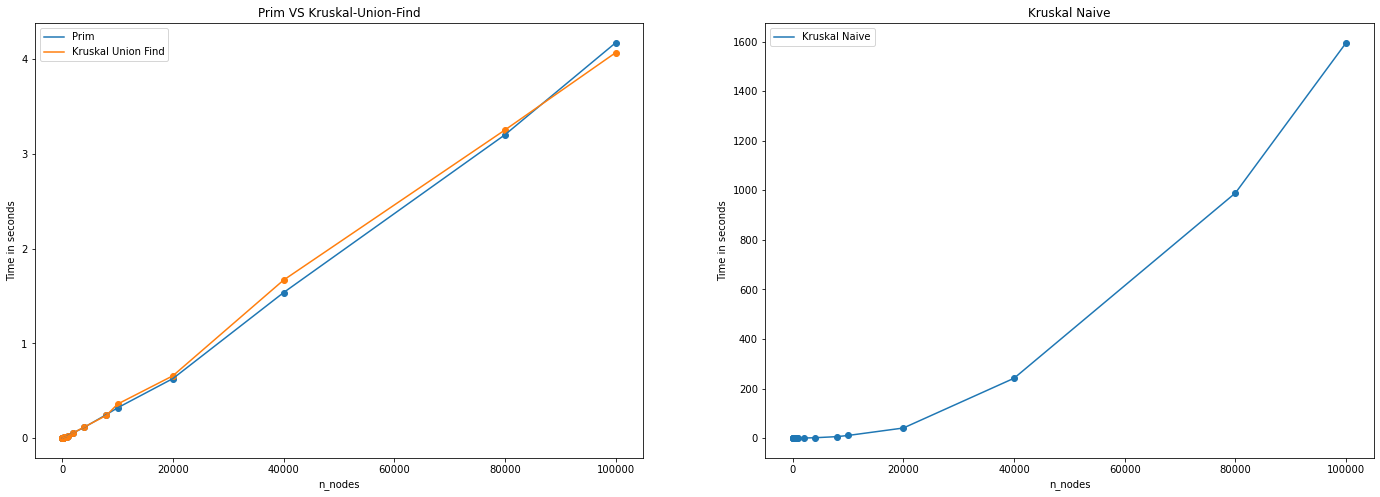

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1,ax2=ax

list_prim = sorted(prim_times.items())
list_kuf = sorted(kuf_times.items())
list_kn = sorted(kn_times.items())

x_prim, y_prim = zip(*list_prim)
x_kuf, y_kuf = zip(*list_kuf)
x_kn, y_kn = zip(*list_kn)

fig.set_figwidth(24)
fig.set_figheight(8)

ax1.plot(x_prim, y_prim)
ax1.scatter(x_prim, y_prim)
ax1.plot(x_kuf, y_kuf)
ax1.scatter(x_kuf, y_kuf)
ax2.plot(x_kn, y_kn)
ax2.scatter(x_kn, y_kn)

ax1.legend(['Prim', "Kruskal Union Find"])
ax1.set_title("Prim VS Kruskal-Union-Find")
ax1.set_xlabel("n_nodes")
ax1.set_ylabel("Time in seconds")
ax2.set_title("Kruskal Naive")
ax2.legend(["Kruskal Naive"])
ax2.set_xlabel("n_nodes")
ax2.set_ylabel("Time in seconds")

fig.show()

From the graphics above we can clearly see that the _Prim_ and _Kruskal Union Find_ algorithms have really similar execution times.
Though we can't say with certaintly that one is strictly better than the other.
Instead as we can see the execution time of the _Kruskal Naive_ algorithm  grows at a much larger rate than the previous algorithms by reaching very quickly unbearable times.  
We can also notice that the execution time of _Prim_ and  _Kruskal-Union-Find_ seems to grow at a liner rate. Instead the _Kruskal Naive_ algorithm seems to have a quadratic tendency.  
  
In conclusion we can surely say that _Kruskal Naive_ performs way much worse if compared with the other two algorithms but is tough to determine which is the best between _Kruskal-Union-Find_ and _Prim_


To make the graphs more readable we decided also to draw a graphic where the x-axis was put on a logarithmic scale

<ipython-input-22-cf2449f75768>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


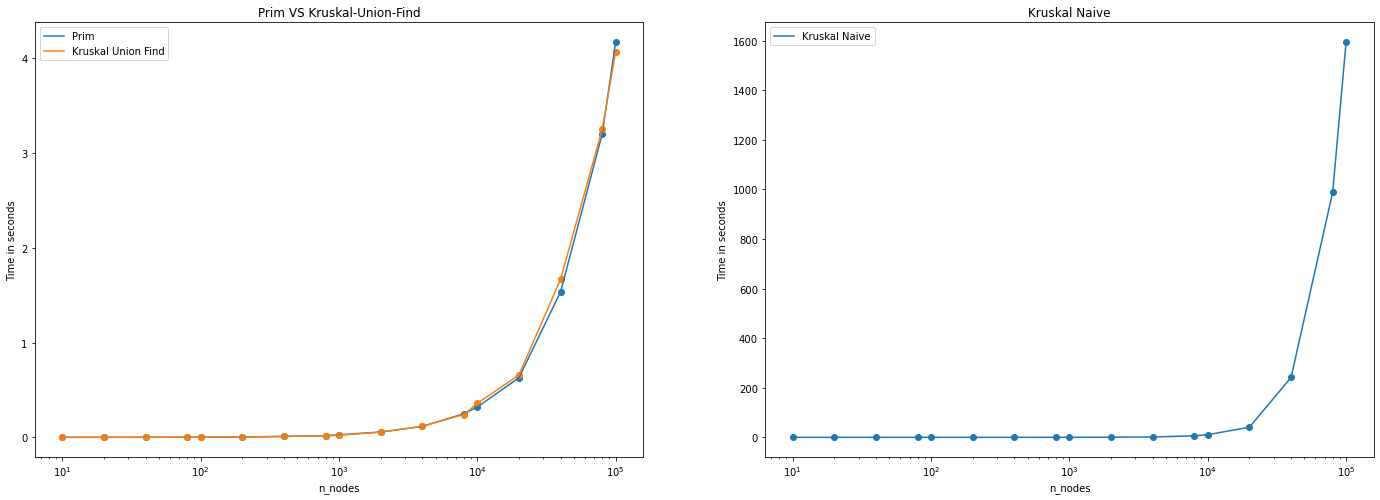

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1,ax2=ax

list_prim = sorted(prim_times.items())
list_kuf = sorted(kuf_times.items())
list_kn = sorted(kn_times.items())

x_prim, y_prim = zip(*list_prim)
x_kuf, y_kuf = zip(*list_kuf)
x_kn, y_kn = zip(*list_kn)

fig.set_figheight(8)
fig.set_figwidth(24)

ax1.plot(x_prim, y_prim)
ax1.scatter(x_prim, y_prim)
ax1.plot(x_kuf, y_kuf)
ax1.scatter(x_kuf, y_kuf)
ax2.plot(x_kn, y_kn)
ax2.scatter(x_kn, y_kn)

ax1.legend(['Prim', "Kruskal Union Find"])
ax1.set_title("Prim VS Kruskal-Union-Find")
ax1.set_xlabel("n_nodes")
ax1.set_ylabel("Time in seconds")
ax1.set_xscale("log")
ax2.set_title("Kruskal Naive")
ax2.legend(["Kruskal Naive"])
ax2.set_xlabel("n_nodes")
ax2.set_ylabel("Time in seconds")
ax2.set_xscale("log")

fig.show()

# Credits

This notebook was realized by:
* **Giacomo Barzon**  (1236597)
* **Diego Mazzalovo** (1236592)
* **Giacomo Greggio** (1234236)